In [7]:
import os
import numpy as np
import tensorflow as tf
from keras.applications import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.losses import BinaryFocalCrossentropy
from keras.metrics import Precision, Recall, AUC
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_auc_score
import matplotlib.pyplot as plt


In [2]:
train_path = "D:\\data conquest\\ESOPHEGEAL CANCER DETECTION\\preprocessed_data"  # Adjust this path
model_path = 'D:\\data conquest\\ESOPHEGEAL CANCER DETECTION\\models\\InceptionV3_optimized_model.h5'


In [79]:
datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,  # 80% Training, 20% Validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

# Training and Validation Generators
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

print("Class Indices:", train_generator.class_indices)
print("Class Indices:", val_generator.class_indices)


Found 6770 images belonging to 2 classes.
Found 1692 images belonging to 2 classes.
Class Indices: {'augmented_esophagus': 0, 'augumented_non_esophagus': 1}
Class Indices: {'augmented_esophagus': 0, 'augumented_non_esophagus': 1}


In [80]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 0.9997046662728883, 1: 1.0002955082742317}


In [81]:
# Load Pre-trained InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune: Unfreeze last 50 layers
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Custom Layers for Classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the Model with Binary Focal Loss
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=BinaryFocalCrossentropy(gamma=2.0),
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 111, 111, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 111, 111, 32)         0         ['batch_normalization_94

In [6]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=5,
    class_weight=class_weights,
    verbose=1
)

# Save the trained model
model.save(model_path)


Epoch 1/5
211/211 [==============================] - 570s 3s/step - loss: 0.0716 - accuracy: 0.8863 - precision: 0.8855 - recall: 0.8876 - auc: 0.9583 - val_loss: 0.0180 - val_accuracy: 0.9766 - val_precision: 0.9750 - val_recall: 0.9785 - val_auc: 0.9969
Epoch 2/5
211/211 [==============================] - 521s 2s/step - loss: 0.0241 - accuracy: 0.9700 - precision: 0.9686 - recall: 0.9715 - auc: 0.9949 - val_loss: 0.0122 - val_accuracy: 0.9808 - val_precision: 0.9695 - val_recall: 0.9928 - val_auc: 0.9991
Epoch 3/5
211/211 [==============================] - 544s 3s/step - loss: 0.0189 - accuracy: 0.9724 - precision: 0.9698 - recall: 0.9750 - auc: 0.9970 - val_loss: 0.0116 - val_accuracy: 0.9850 - val_precision: 0.9820 - val_recall: 0.9879 - val_auc: 0.9986
Epoch 4/5
211/211 [==============================] - 532s 3s/step - loss: 0.0167 - accuracy: 0.9797 - precision: 0.9792 - recall: 0.9801 - auc: 0.9975 - val_loss: 0.0114 - val_accuracy: 0.9862 - val_precision: 0.9764 - val_recall: 0

c:\Users\Sri Aravindh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


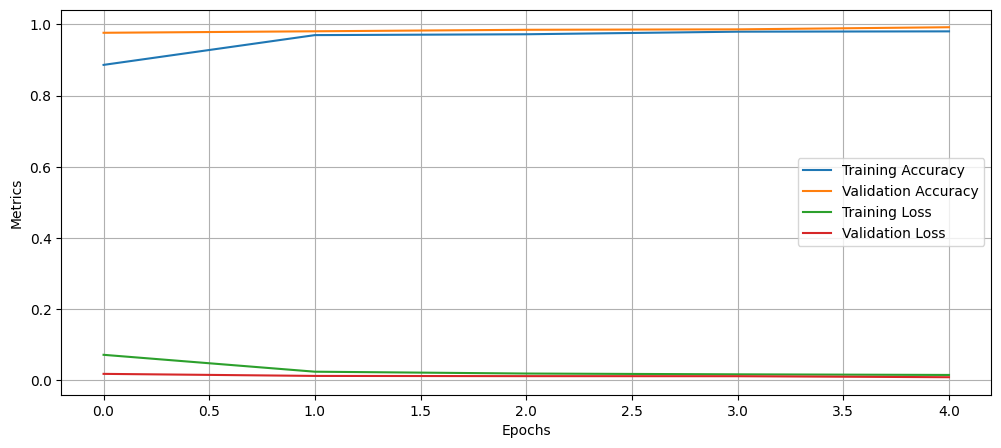

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid()
plt.show()


In [83]:
model = load_model("D:\\data conquest\\ESOPHEGEAL CANCER DETECTION\\models\\InceptionV3_optimized_model.h5")
val_loss, val_acc, val_precision, val_recall, val_auc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"AUC: {val_auc:.4f}")


53/53 [==============================] - 245s 5s/step - loss: 0.0091 - accuracy: 0.9911 - precision: 0.9860 - recall: 0.9965 - auc: 0.9992
Validation Loss: 0.0091
Validation Accuracy: 99.11%
Precision: 0.9860
Recall: 0.9965
AUC: 0.9992


1/1 [==============================] - 4s 4s/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       846
         1.0       0.99      0.99      0.99       846

    accuracy                           0.99      1692
   macro avg       0.99      0.99      0.99      1692
weighted avg       0.99      0.99      0.99      1692



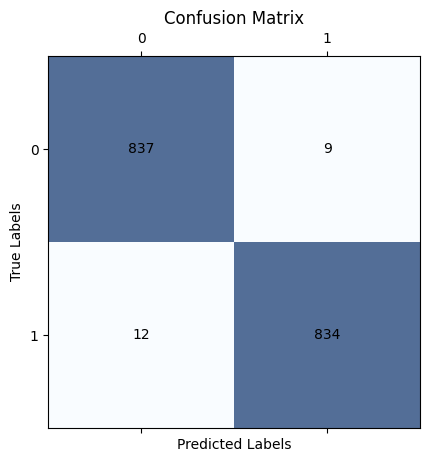

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Get the total number of samples in the validation set
total_samples = len(val_generator.filenames)

# Initialize lists to collect all true labels and predicted probabilities
all_true_labels = []
all_pred_probs = []

# Loop through all batches in the validation generator
for i in range(len(val_generator)):
    x_batch, y_true_batch = val_generator[i]  # Get the i-th batch
    all_true_labels.extend(y_true_batch)
    y_pred_prob_batch = model.predict(x_batch)
    all_pred_probs.extend(y_pred_prob_batch)

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_pred_probs = np.array(all_pred_probs)

# Set the optimal threshold and get predicted labels
optimal_threshold = 0.5
all_pred_labels = (all_pred_probs >= optimal_threshold).astype(int)

# Classification Report
print("Classification Report:")
print(classification_report(all_true_labels, all_pred_labels))

# Confusion Matrix
cm = confusion_matrix(all_true_labels, all_pred_labels)
plt.matshow(cm, cmap='Blues', alpha=0.7)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title("Confusion Matrix")
plt.show()




In [84]:
print(f"Number of samples in y_true: {len(y_true)}")
print(f"Unique labels and their counts: {np.unique(y_true, return_counts=True)}")


Number of samples in y_true: 32
Unique labels and their counts: (array([0., 1.], dtype=float32), array([20, 12], dtype=int64))


In [85]:
print(val_generator.classes)

[0 0 0 ... 1 1 1]


In [86]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal Threshold:", optimal_threshold)

# Predict with the optimal threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)
print(classification_report(y_true, y_pred_optimal))


Optimal Threshold: 0.82989997
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [87]:
auc_score = roc_auc_score(y_true, y_pred_prob)
print(f"AUC-ROC Score: {auc_score:.4f}")

AUC-ROC Score: 1.0000


53/53 [==============================] - 172s 3s/step
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.51      0.52       846
           1       0.52      0.52      0.52       846

    accuracy                           0.52      1692
   macro avg       0.52      0.52      0.52      1692
weighted avg       0.52      0.52      0.52      1692



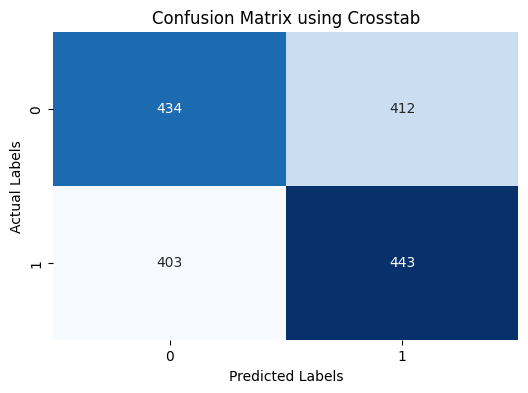

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Get true and predicted labels
y_true = val_generator.classes
y_pred = model.predict(val_generator, verbose=1)
y_pred = (y_pred > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary labels (0 or 1)

# Create a DataFrame for crosstab
confusion_df = pd.crosstab(pd.Series(y_true, name='Actual'), pd.Series(y_pred, name='Predicted'))

# Display classification report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Crosstab")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()


In [30]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

def sliding_window(image, step_size, window_size):
    """Generator for sliding window."""
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

# Load the pre-trained VGG16 model
model = load_model("D:\\data conquest\\ESOPHEGEAL CANCER DETECTION\\models\\InceptionV3_optimized_model.h5")  # Replace with actual model file

# Load and preprocess image
image = cv2.imread("D:\\data conquest\\ESOPHEGEAL CANCER DETECTION\\preprocessed_data\\augmented_esophagus\\ff16a698-7cf6-419a-9472-0c0cd2a87e96.jpg")  # Replace with actual image file
image = cv2.resize(image, (512, 512))  # Resize for consistency

# Define window parameters
window_size = (128, 128)  # Size of sliding window
step_size = 32  # Step size for sliding

# Store detected regions
detections = []

for (x, y, window) in sliding_window(image, step_size, window_size):
    if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
        continue
    
    # Preprocess window for model input
    window = cv2.resize(window, (224, 224))  # Resize to match VGG16 input size
    window = window.astype("float32") / 255.0  # Normalize
    window = np.expand_dims(window, axis=0)  # Add batch dimension
    
    # Predict abnormality probability
    prob = model.predict(window)[0][0]  # Assuming binary classification
    
    if prob <0.3 :# Threshold for detection
        detections.append((x, y, x + window_size[0], y + window_size[1], prob))

# Apply Non-Maximum Suppression (NMS) to refine detections
def non_maximum_suppression(detections, threshold=0.3):
    """NMS to remove overlapping boxes."""
    detections = sorted(detections, key=lambda x: x[4], reverse=True)
    final_detections = []
    while detections:
        best = detections.pop(0)
        final_detections.append(best)
        detections = [d for d in detections if iou(best, d) < threshold]
    return final_detections

def iou(box1, box2):
    """Calculate Intersection over Union (IoU) for two bounding boxes."""
    x1, y1, x2, y2, _ = box1
    x1b, y1b, x2b, y2b, _ = box2
    inter_x1, inter_y1 = max(x1, x1b), max(y1, y1b)
    inter_x2, inter_y2 = min(x2, x2b), min(y2, y2b)
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2b - x1b) * (y2b - y1b)
    return inter_area / float(box1_area + box2_area - inter_area)

# Get final bounding boxes
detections = non_maximum_suppression(detections)

# Draw detections on image
for (x1, y1, x2, y2, _) in detections:
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Show result
cv2.imshow("Detection", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 196ms/step


VALIDATING WITH NEW DATA

1/1 [==============================] - 2s 2s/step


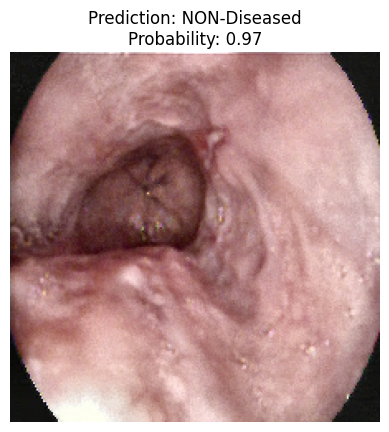

Prediction Label: NON-Diseased
Prediction Probability: 0.97


In [51]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Path to the model and test image
model_path = 'D:\\data conquest\\ESOPHEGEAL CANCER DETECTION\\models\\InceptionV3_optimized_model.h5'
image_path = "D:\\data conquest\\ESOPHEGEAL CANCER DETECTION\\misclassification_1\\7f7f8496-911d-4f4f-bbeb-9b7e91e6e4f2.jpg" # Change this to your image path

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Load and preprocess the image
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image) / 255.0  # Normalize to [0, 1] range
image_array = np.expand_dims(image_array, axis=0)  # Expand dimensions for batch processing

# Predict the probability
probability = model.predict(image_array)[0][0]  # Get the predicted probability
label = "NON-Diseased" if probability >= 0.5 else "Diseased"

# Display the image and prediction
plt.imshow(image)
plt.axis('off')
plt.title(f"Prediction: {label}\nProbability: {probability:.2f}")
plt.show()

print(f"Prediction Label: {label}")
print(f"Prediction Probability: {probability:.2f}")


SEGMENTATION

1/1 [==============================] - 0s 421ms/step


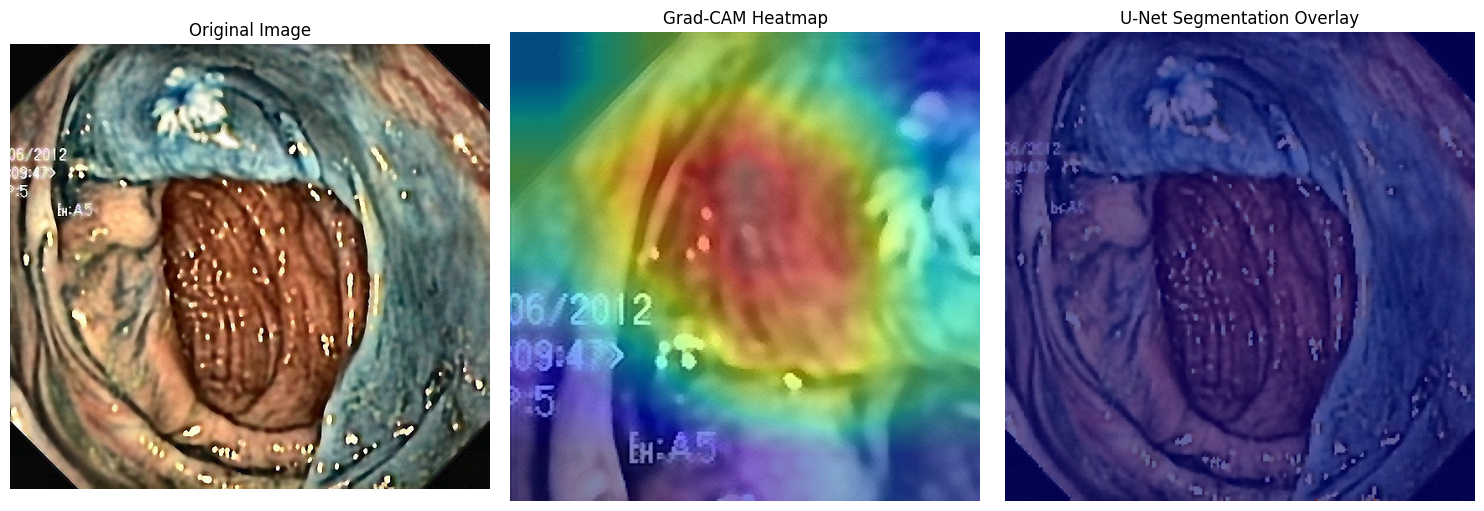

In [18]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


def build_unet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder
    up4 = UpSampling2D((2, 2))(conv3)
    up4 = concatenate([up4, conv2])
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up4)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up5 = UpSampling2D((2, 2))(conv4)
    up5 = concatenate([up5, conv1])
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model


def grad_cam(model, img_array, layer_name, pred_index=None):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0] * pooled_grads

    heatmap = tf.reduce_mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


def overlay_segmentation(original_img, seg_mask, alpha=0.6):
    colored_mask = cv2.applyColorMap(np.uint8(255 * seg_mask), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.array(original_img), 1 - alpha, colored_mask, alpha, 0)
    return overlay


def combined_gradcam_unet(model, unet_model, img_path, layer_name):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    heatmap = grad_cam(model, img_array, layer_name)
    heatmap = cv2.resize(heatmap, (224, 224))

    # U-Net Prediction
    seg_mask = unet_model.predict(np.expand_dims(img_array[0], axis=0))[0, :, :, 0]
    seg_mask = (seg_mask > 0.5).astype(np.float32)

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image.load_img(img_path))
    axes[0].set_title("Original Image")

    axes[1].imshow(image.load_img(img_path))
    axes[1].imshow(heatmap, cmap='jet', alpha=0.5)
    axes[1].set_title("Grad-CAM Heatmap")

    overlay_img = overlay_segmentation(img, seg_mask)
    axes[2].imshow(overlay_img)
    axes[2].set_title("U-Net Segmentation Overlay")

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# Model Initialization and Training
unet_model = build_unet()
# Dummy data generation for demonstration
X_dummy = np.random.rand(10, 224, 224, 3)
y_dummy = np.random.randint(0, 2, (10, 224, 224, 1))
unet_model.fit(X_dummy, y_dummy, epochs=1)

unet_model.save('unet_model.h5')

model_path = 'D:/data conquest/ESOPHEGEAL CANCER DETECTION/models/InceptionV3_optimized_model.h5'
model = tf.keras.models.load_model(model_path)
unet_model_path = 'unet_model.h5'
unet_model = tf.keras.models.load_model(unet_model_path)

image_path = 'D:\\data conquest\\ESOPHEGEAL CANCER DETECTION\\preprocessed_data\\augmented_esophagus\\ff9b9cd4-6290-4d36-9b5c-f51c523c135c.jpg'
combined_gradcam_unet(model, unet_model, image_path, layer_name='mixed10')


In [ ]:
import labelme